In [24]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Path
folder = './run_data/'

In [2]:
# Scan through folders
files = os.listdir(folder)
print("There are {} files".format(len(files)))

# Read files under folder to dataframe
frame = pd.DataFrame()
for file in files:
    file = folder + file
    df_temp = pd.read_csv(file, sep='|', encoding="utf8", parse_dates=[4])
    frame = pd.concat([frame, df_temp])
    
print("Read successfully {} lines".format(len(frame)))

There are 13 files


/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Read successfully 56428 lines


In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56428 entries, 0 to 2992
Data columns (total 10 columns):
author        12473 non-null object
author.1      0 non-null float64
contents      25604 non-null object
contents.1    0 non-null float64
date          56428 non-null object
tags          1857 non-null object
tags.1        0 non-null float64
title         56428 non-null object
tweetid       56428 non-null float64
url           51183 non-null object
dtypes: float64(4), object(6)
memory usage: 4.7+ MB


In [4]:
frame.drop(labels=['author.1','contents.1','tags.1'],axis=1,inplace=True)
frame.head()

,author,contents,date,tags,title,tweetid,url
0,Amy Dockser Marcus,"For years, Brad Margus has juggled two goals a...",Sat Dec 27 02:15:25 +0000 2014,NaN,Parents Start Companies to Cure Children,5.486634e+17,http://on.wsj.com/1vyYbra
1,Liz Hoffman,More healthcare mergers ahead? The sector cert...,Fri Dec 26 18:22:17 +0000 2014,NaN,"RT @lizrhoffman: J&amp;J, Gilead among healthc...",5.485443e+17,http://on.wsj.com/144DH2Q
2,NaN,NaN,Fri Dec 26 17:35:42 +0000 2014,NaN,RT @stefaniei: How has the health law's first ...,5.485326e+17,NaN
3,NaN,NaN,Fri Dec 26 17:08:34 +0000 2014,NaN,"RT @lizrhoffman: Allergan dodges a bullet, Apo...",5.485258e+17,NaN
4,NaN,NaN,Fri Dec 26 17:07:37 +0000 2014,NaN,RT @Loftus: Faces of the Health Law: Read more...,5.485256e+17,http://graphics.wsj.com/HealthProfiles/


In [5]:
frame['date'] = pd.to_datetime(frame['date'])
frame.dropna(subset=['contents'],axis=0,inplace=True)
frame['year'] = frame['date'].apply(lambda row: row.strftime("%Y"))
frame['length'] = frame['contents'].apply(lambda row: len(row))
frame['year'] = frame['year'].astype('int')
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25604 entries, 0 to 2992
Data columns (total 9 columns):
author      11109 non-null object
contents    25604 non-null object
date        25604 non-null datetime64[ns, UTC]
tags        1856 non-null object
title       25604 non-null object
tweetid     25604 non-null float64
url         25604 non-null object
year        25604 non-null int64
length      25604 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(5)
memory usage: 2.0+ MB


In [6]:
frame = frame[frame['year'] > 2012]
frame.shape

(24758, 9)

In [9]:
frame = frame[['date','length']]
frame.head()

,date,length
0,2014-12-27 02:15:25+00:00,349
1,2014-12-26 18:22:17+00:00,278
7,2014-12-26 14:41:33+00:00,387
10,2014-12-26 04:36:49+00:00,387
11,2014-12-26 02:18:43+00:00,591


In [12]:
frame = frame.set_index('date')
frame.index

DatetimeIndex(['2014-12-27 02:15:25+00:00', '2014-12-26 18:22:17+00:00',
               '2014-12-26 14:41:33+00:00', '2014-12-26 04:36:49+00:00',
               '2014-12-26 02:18:43+00:00', '2014-12-26 02:18:42+00:00',
               '2014-12-25 03:00:55+00:00', '2014-12-25 01:37:47+00:00',
               '2014-12-24 04:32:51+00:00', '2014-12-24 04:32:51+00:00',
               ...
               '2014-10-18 18:42:02+00:00', '2014-10-18 17:39:15+00:00',
               '2014-10-18 16:37:08+00:00', '2014-10-18 15:35:07+00:00',
               '2014-10-18 14:33:10+00:00', '2014-10-18 13:30:10+00:00',
               '2014-10-18 12:28:03+00:00', '2014-10-18 11:23:14+00:00',
               '2014-10-18 10:11:10+00:00', '2014-10-18 09:09:02+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=24758, freq=None)

In [13]:
y = frame['length'].resample('MS').mean()

/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


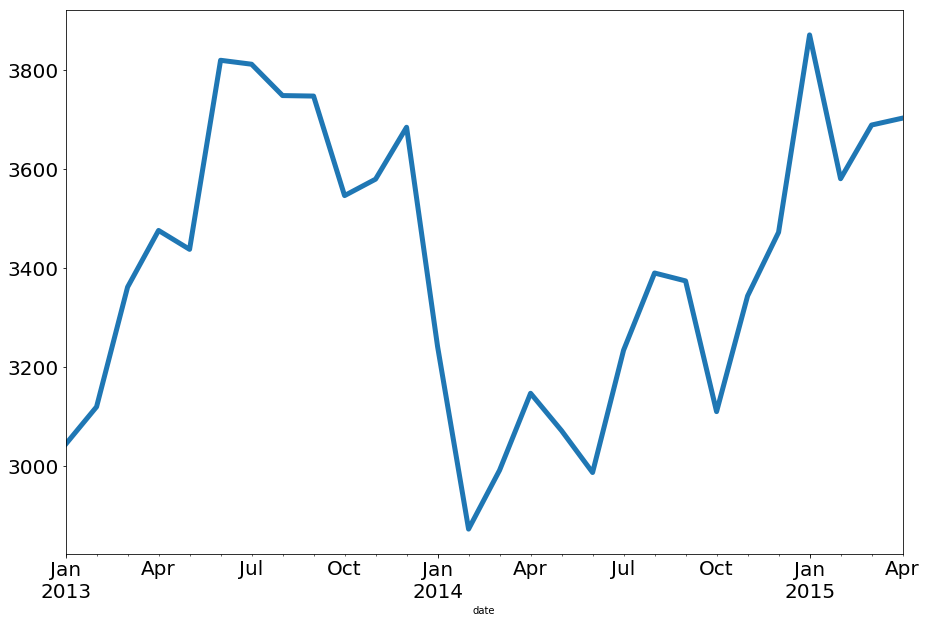

In [17]:
y.plot(figsize=(15,10), linewidth=5, fontsize=20)
plt.show()

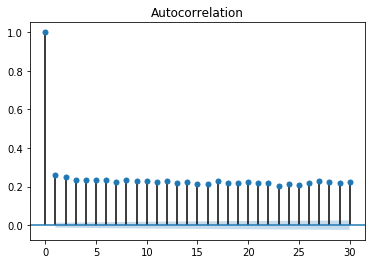

In [18]:
plot_acf(frame,lags=30);

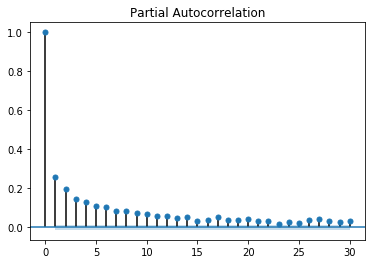

In [21]:
plot_pacf(frame, lags=30, method='ywmle');

/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


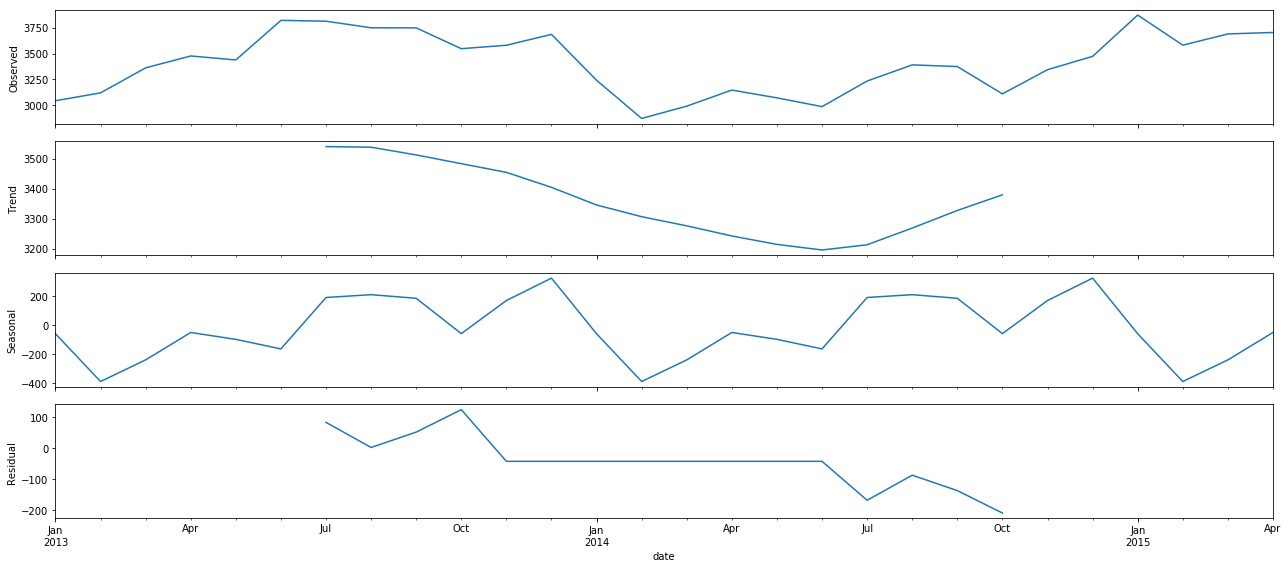

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# Decompose timeseries
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


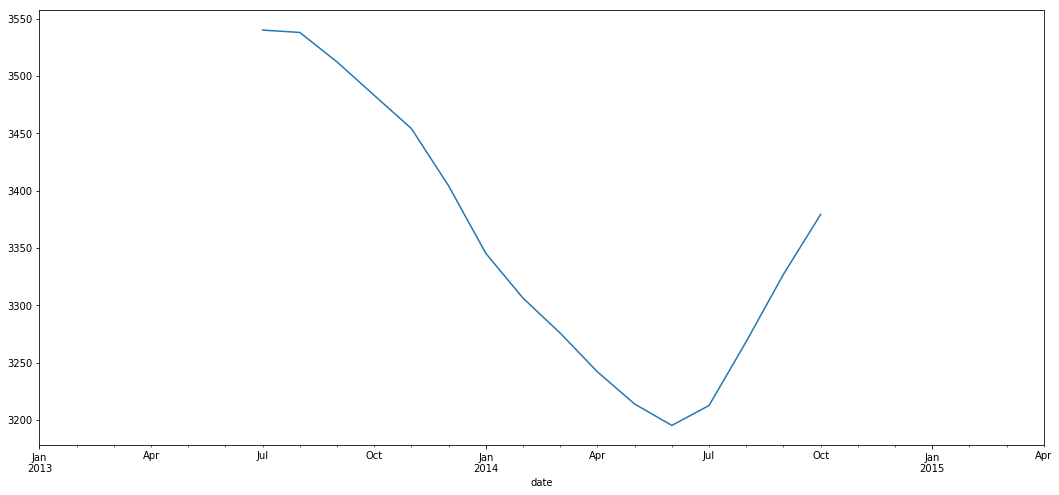

In [27]:
decomposition.trend.plot()

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

NameError: name 'itertools' is not defined